In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

import pyfftw.interfaces.numpy_fft as fft
import pyfftw
import galsim

from scripts.BTK_generator import BTK_blend_generator as btk_generator

# 0. Goal of this Notebook

David said it would be good to better understand what was happening with the FT, so he suggested writing in code & by hand what the FT of a round 2D gaussian and an elliptical 2D gaussian is.

This notebook is the code portion of this task. 

# 1. Round Gaussian FT

In [2]:
blend_images, isolated_images, psf = btk_generator(catalog_name=None,
                                                  stamp_size=24.0,
                                                  max_number=1,
                                                  max_shift=0,
                                                  batch_size=10,
                                                  sampling_func=None,
                                                  survey="LSST",
                                                  add_noise="all")

Generating blends for LSST survey:   0%|          | 0/10 [00:00<?, ?it/s]

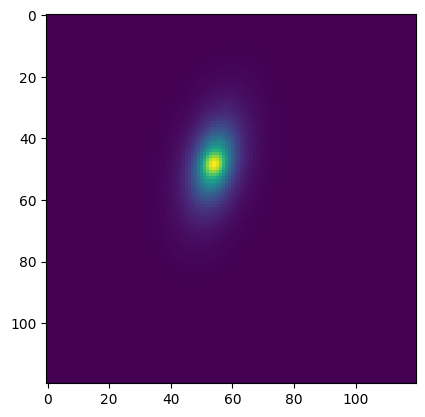

In [5]:
plt.imshow(isolated_images[0][0][0])

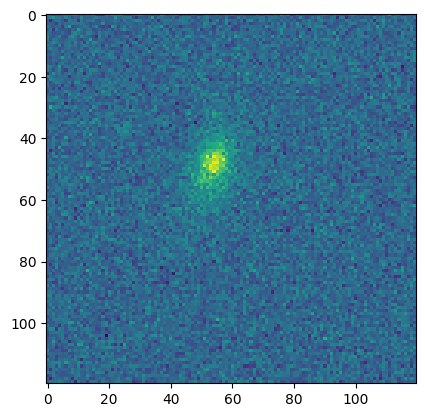

In [4]:
plt.imshow(blend_images[0][0])